# Lesson 2 : LangGraph Components

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


C:\Users\NahashonOsinde\AppData\Local\Temp\ipykernel_43832\144666821.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=4) #increased number of results


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html).

In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [5]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

c:\Users\NahashonOsinde\miniconda3\envs\LangChain\Lib\site-packages\pygraphviz\agraph.py:1403: RuntimeWarning: Warning: Could not load "C:\Users\NahashonOsinde\miniconda3\envs\LangChain\Library\bin\gvplugin_pango.dll" - It was found, so perhaps one of its dependents was not.  Try ldd.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


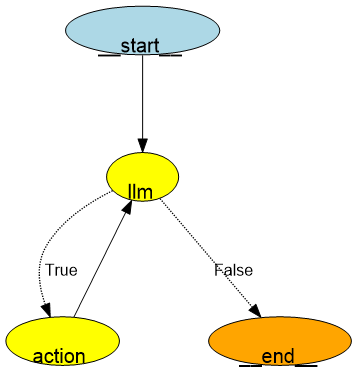

In [7]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [15]:
messages = [HumanMessage(content="What is Tamara with respect to Lipid nano particles?")] #What is the weather in sf?
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Tamara Lipid nanoparticles'}, 'id': 'call_97gSkt8iWUnwpRqo6sgot87a', 'type': 'tool_call'}
Back to the model!


In [16]:
result

{'messages': [HumanMessage(content='What is Tamara with respect to Lipid nano particles?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_97gSkt8iWUnwpRqo6sgot87a', 'function': {'arguments': '{"query":"Tamara Lipid nanoparticles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 156, 'total_tokens': 178, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'id': 'chatcmpl-C9T3d10fEiQPdDK6Ydixyh3MO7i1Q', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a3fc4c2f-89e5-4bb8-bdcb-cbe474ce58db-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'

In [17]:
result['messages'][-1].content

'TAMARA is a nanoparticle formulation system that utilizes microfluidic technology to synthesize lipid-based nanoparticles, including lipid nanoparticles (LNPs). It offers a versatile platform for researchers to create various nanoparticles such as RNA LNPs, liposomes, solid lipid nanoparticles (SLNs), and polymeric nanoparticles. \n\nKey features of the TAMARA system include:\n\n1. **Microfluidics Technology**: TAMARA uses a bottom-up, self-assembly approach with recyclable microfluidic chips. These chips feature two mixing designs, the baffle or herringbone mixer, allowing researchers to choose a mixing method that suits their research objectives.\n\n2. **R&D Versatility**: The system integrates all research and development stages, handling volumes from low-volume screening (200µL) to in-vivo scale studies (30mL per batch). This eliminates the need to change models during scaling up.\n\n3. **Precise Control**: It offers control over the nanoparticle size, crucial for achieving unifor

In [20]:
messages = [HumanMessage(content="What is Tamara with respect to Lipid nano particles and how can it be optimised?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Tamara lipid nanoparticles optimization'}, 'id': 'call_Uavdzwp1kmxRkpZ9FZsTeeGJ', 'type': 'tool_call'}
Back to the model!


In [21]:
result['messages'][-1].content

'Tamara is a platform used for the formulation of lipid nanoparticles (LNPs) and other types of nanoparticles. It is designed to facilitate the development and optimization of LNP formulations, particularly for the effective delivery of various nucleic acids such as mRNA, siRNA, tRNA, DNA, saRNA, or antisense oligonucleotides (ASO) to target cells or organs.\n\n### Features of Tamara:\n- **Versatility**: It can synthesize a wide range of polymeric and lipid-based nanoparticles, including liposomes and solid lipid nanoparticles (SLNs).\n- **Microfluidics Technology**: Utilizes a bottom-up, self-assembly approach for synthesizing LNPs. The platform features recyclable microfluidic chips with advanced cleaning protocols. The chips include versatile mixing methods (baffle or herringbone mixer), allowing customization for specific research goals.\n- **Control and Consistency**: Offers precise control over critical parameters like nanoparticle size, polydispersity index (PDI), and encapsulat

In [22]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.

query = "What is Tamara with respect to Lipid nano particles? \
Who are the cofounders of the company that built Tamara and when was it founded." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Tamara lipid nanoparticles'}, 'id': 'call_Xk4Mz8NeoYqvTgvChVAU4T4v', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Tamara nanoparticle company founders'}, 'id': 'call_pmifrsSFqAHKP8Fmy2tASyPE', 'type': 'tool_call'}
Back to the model!


In [27]:
print(result['messages'][-1].content)

Tamara is a microfluidic-based nanoparticle formulation system developed by Inside Therapeutics. It specializes in synthesizing a range of polymeric and lipid-based nanoparticles, such as RNA-LNPs, liposomes, and solid lipid nanoparticles (SLNs). The platform is designed to provide precise control over nanoparticle size and offers flexibility and versatility across various research and development stages. It integrates all R&D nanoparticle formulation stages, allowing a smooth transition from low-volume screening to in-vivo scale studies without changing models.

The cofounders of the company behind Tamara, Inside Therapeutics, include Robin, a micro and nanotechnology engineer, and Matthieu Kerhuel, who is also the Chief Technology Officer (CTO).


In [25]:
result

{'messages': [HumanMessage(content='What is Tamara with respect to Lipid nano particles? Who are the cofounders of the company that built Tamara and when was it founded.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Xk4Mz8NeoYqvTgvChVAU4T4v', 'function': {'arguments': '{"query":"Tamara lipid nanoparticles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 175, 'total_tokens': 196, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_80956533cb', 'id': 'chatcmpl-C9T7oqW8cOSmhyl1j3vR174WUfLuf', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a3090bdd-829b-45fc-82